Loaded 285 cases.
Case 403:
  Continuous Solution - Value: -2.13519, Penalty: 22.96628, Score: 0.27765
  Exact Solution - Value: -3.04441, Penalty: 0.00000, Score: 0.03367
  Qaoa Solution - Value: -0.00000, Penalty: 62.26000, Score: 0.68867

Case 404:
  Continuous Solution - Value: -11.74942, Penalty: 6.46974, Score: 0.05413
  Exact Solution - Value: -15.21434, Penalty: 1.58356, Score: 0.04991
  Qaoa Solution - Value: -0.00000, Penalty: 301.56000, Score: 0.89596

Case 307:
  Continuous Solution - Value: -4.61510, Penalty: -0.00000, Score: 0.10957
  Exact Solution - Value: -4.61510, Penalty: 0.00000, Score: 0.10957
  Qaoa Solution - Value: -30.47893, Penalty: 2.40997, Score: 0.78085

Case 308:
  Continuous Solution - Value: -2.02332, Penalty: -0.00000, Score: 0.00771
  Exact Solution - Value: -2.02332, Penalty: 0.00000, Score: 0.00771
  Qaoa Solution - Value: -0.00000, Penalty: 258.55118, Score: 0.98459

Case 245:
  Continuous Solution - Value: -7.44408, Penalty: -0.00000, Score: 0.0955

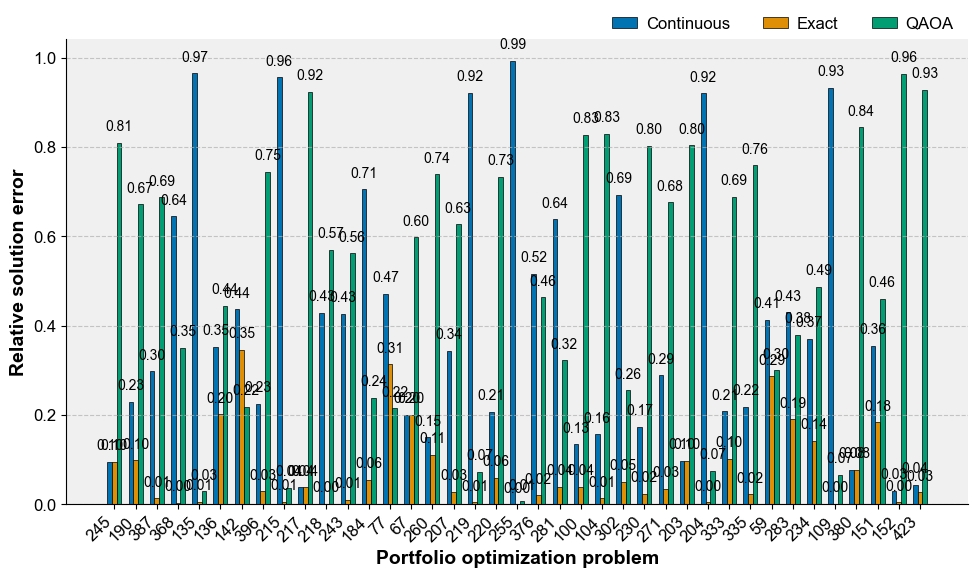

In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)
    

def compare_solutions(data):
    results = {}
    
    for case_id, case_data in data.items():
        n_qubits = case_data["hyperparams"]["n_qubits"]
        cont_sol = case_data.get("continuous_variables_solution", {})
        exact_sol = case_data.get("exact_solution", {})
        qaoa_sol = case_data.get("qaoa_solution", {})
        budget = case_data["hyperparams"]["budget"]
        penalizer = 1
        
        cont_value = cont_sol.get("value", 0)
        cont_penalty = penalizer*cont_sol.get("left_overs", 0)
        cont_score = cont_value - cont_penalty

        exact_budgets = exact_sol.get("result_with_budget", [])[0]
        exact_value = exact_budgets.get("objective_value", 0)
        exact_penalty = penalizer*abs(exact_budgets["difference"])
        exact_score = exact_value - exact_penalty

        qaoa_value = qaoa_sol.get("objective_values", [])[-1]
        qaoa_budgets = qaoa_sol.get("result_with_budget", [])[-1]
        qaoa_penalty = penalizer*abs(qaoa_budgets["difference"])
        qaoa_score = qaoa_value - qaoa_penalty

        total_score = cont_score + exact_score + qaoa_score
        #min_score = min(cont_score, exact_score, qaoa_score)
        #max_score = max(cont_score, exact_score, qaoa_score)
        cont_normalized = cont_score/total_score #2*(cont_score - min_score) / (max_score - min_score) - 1
        exact_normalized = exact_score/total_score #2*(exact_score - min_score) / (max_score - min_score) - 1
        qaoa_normalized = qaoa_score/total_score #2*(qaoa_score - min_score) / (max_score - min_score) - 1

        results[case_id] = {
            "continuous": {"value": cont_value, "penalty": cont_penalty, "score": cont_normalized, "n_qubits": n_qubits},
            "exact": {"value": exact_value, "penalty": exact_penalty, "score": exact_normalized},
            "qaoa": {"value": qaoa_value, "penalty": qaoa_penalty, "score": qaoa_normalized},
        }
    
    return results

def plot_scores(results, save_path=None, dpi=300, fig_width=10, fig_height=6):
    """
    Creates a publication-quality bar plot comparing scores across different methods.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing the results for each case and method.
    save_path : str, optional
        Path to save the figure. If None, the figure is displayed but not saved.
    dpi : int, optional
        Resolution of the saved figure in dots per inch.
    fig_width : float, optional
        Width of the figure in inches.
    fig_height : float, optional
        Height of the figure in inches.
    
    Returns:
    --------
    fig, ax : tuple
        Figure and axes objects for further customization if needed.
    """
    
    # Set publication-quality parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        'font.size': 14,
        'axes.linewidth': 0.8,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'legend.frameon': False,
        'legend.handlelength': 1.5,
        'legend.handletextpad': 0.5
    })
    
    # Extract data
    cases = list(results.keys())
    continuous_scores = [results[case]["continuous"]["score"] for case in cases]
    exact_scores = [results[case]["exact"]["score"] for case in cases]
    qaoa_scores = [results[case]["qaoa"]["score"] for case in cases]
    n_qubits = [results[case]["continuous"]["n_qubits"] for case in cases][0]
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Set smoke gray background for plotting area
    ax.set_facecolor('#f0f0f0')  # Light smoke gray
    
    # Define bar positions
    x = np.arange(len(cases))
    width = 0.22
    
    # Define a professional color palette (colorblind-friendly)
    colors = ['#0173B2', '#DE8F05', '#029E73']
    
    # Plot bars with error bars if available
    cont_bars = ax.bar(x - width, continuous_scores, width, label="Continuous", 
                        color=colors[0], edgecolor='black', linewidth=0.5)
    exact_bars = ax.bar(x, exact_scores, width, label="Exact", 
                         color=colors[1], edgecolor='black', linewidth=0.5)
    qaoa_bars = ax.bar(x + width, qaoa_scores, width, label="QAOA", 
                        color=colors[2], edgecolor='black', linewidth=0.5)
    
    # Add value labels on top of bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02*max(continuous_scores + exact_scores + qaoa_scores),
                    f'{height:.2f}', ha='center', va='bottom', fontsize=10)
    
    add_value_labels(cont_bars)
    add_value_labels(exact_bars)
    add_value_labels(qaoa_bars)
    
    # Customize axes
    ax.set_xlabel("Portfolio optimization problem", fontweight='bold')
    ax.set_ylabel("Relative solution error", fontweight='bold')
    #ax.set_title(f"Comparison of methods for {n_qubits} qubits", fontweight='bold', fontsize=16)
    
    # Set x-ticks
    ax.set_xticks(x)
    ax.set_xticklabels(cases, rotation=45, ha='right')
    
    # Add grid lines for y-axis only, behind the bars
    ax.yaxis.grid(True, linestyle='--', alpha=0.7, zorder=0)
    
    # Customize spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend in optimal position
    ax.legend(loc='upper right', ncol=3, bbox_to_anchor=(1, 1.08))
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    return fig, ax

def main():
    #file_path = "portfolio_optimization_results.json"  # Update with actual path
    data = {}
    # Get file names like portfolio_optimization_results_batch_ from the parent directory
    files = [file for file in os.listdir("../") if "portfolio_optimization_results_batch_" in file]
    for file in files:
        data.update(load_json("../" + file))
    
    print(f"Loaded {len(data)} cases.")
    nqubits = 10
    path = f"./{nqubits}_qubits"
    results = compare_solutions(data)
    
    for case, comparison in results.items():
        print(f"Case {case}:")
        for method, values in comparison.items():
            print(f"  {method.capitalize()} Solution - Value: {values['value']:.5f}, Penalty: {values['penalty']:.5f}, Score: {values['score']:.5f}")
        print()
    
    subset_of_results = {}
    for key in list(results.keys()):
        assets_to_qubits = data[key]["hyperparams"]["assets_to_qubits"]
        n_qubits = sum([len(v) for v in assets_to_qubits.values()])
        if n_qubits == nqubits:
            subset_of_results[key] = results[key]
    
    plot_scores(subset_of_results, save_path = path)
    return data

data = main()

In [2]:
#file_path = "experiments_data.json"
#data = load_json(file_path)["data"]
#print(json.dumps(data[20], indent=4))


In [3]:
print(json.dumps(data["46"], indent=4))

{
    "hyperparams": {
        "stocks": [
            "CRM",
            "MRK"
        ],
        "start": "2015-01-01",
        "end": "2025-01-01",
        "risk_aversion": 3,
        "n_qubits": 4,
        "budget": 596.8800201416016,
        "log_encoding": true,
        "layers": 4,
        "prices_now": {
            "CRM": 334.3299865722656,
            "MRK": 99.4800033569336
        },
        "assets_to_qubits": {
            "CRM": [
                0
            ],
            "MRK": [
                1,
                2,
                3
            ]
        }
    },
    "continuous_variables_solution": {
        "weights": {
            "CRM": 0.48272738461599135,
            "MRK": 0.5172726153840087
        },
        "allocation": {
            "CRM": 1,
            "MRK": 2
        },
        "value": -23.224667844140114,
        "left_overs": 63.59002680592414
    },
    "exact_solution": {
        "smallest_eigenvalues": [
            -0.6611176477861292
       